<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [37]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

// needed to generate the Table of contents 
// taken from github.com/kmahelona/ipython_notebook_goodies

<IPython.core.display.Javascript object>

## Data Pre-Processing

Let's load the data files generated in the EDA notebook.

In [38]:
# import modules
import pandas as pd
import numpy as np

In [39]:
train_df = pd.read_csv('../data/train_op_regime2_FD001.csv')
test_df = pd.read_csv('../data/test_op_regime2_FD001.csv')

In [40]:
train_df.head()

,unit_number,cycle_time,op_setting_1,op_setting_2,op_setting_3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,dataset,op_regime,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,FD001,2,-191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,FD001,2,-190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,FD001,2,-189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,FD001,2,-188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,FD001,2,-187


In [41]:
test_df.head()

,unit_number,cycle_time,op_setting_1,op_setting_2,op_setting_3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,dataset,op_regime,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8.4052,0.03,392,2388,100.0,38.86,23.3735,FD001,2,-142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8.3803,0.03,393,2388,100.0,39.02,23.3916,FD001,2,-141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8.4441,0.03,393,2388,100.0,39.08,23.4166,FD001,2,-140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8.3917,0.03,391,2388,100.0,39.00,23.3737,FD001,2,-139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8.4031,0.03,390,2388,100.0,38.99,23.4130,FD001,2,-138


In [42]:
print(test_df.shape)

(13096, 29)


### Create dummy or indicator features for categorical variables
While there are no categorical variables that need to be converted, we can create a new label such that we can consider this prediction problem as a **calssification** problem. 

For now we will bin the data in 3, arbitary, categories:
- **Level 1 :** less than 50 cycles remaining until failure (Alarm)
- **Level 2 :** less than 100 cycle remaining until failure (Warning)
- **Level 3 :** over 100 cycles remaining until failure (Normal)

We might change these boundaries later to optimize for performance.

In [43]:
#setting an arbitary boundary at 50 adn 125 cycles for the binning\
first_boundary = -100
second_boundary = -50
train_df['status'] = pd.cut(train_df['RUL'],[-np.inf,first_boundary,second_boundary,0],labels=[3,2,1])
test_df['status'] = pd.cut(train_df['RUL'],[-np.inf,first_boundary,second_boundary,0],labels=[3,2,1])

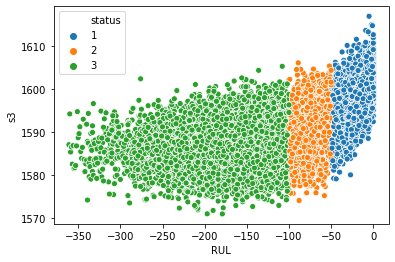

In [44]:
import seaborn as sns
sns.scatterplot('RUL','s3',data = train_df, hue='status')

In [45]:
def distplot_with_hue(data=None, x=None, hue=None, row=None, col=None, legend=True, **kwargs):
    _, bins = np.histogram(data[x].dropna())
    g = sns.FacetGrid(data, hue=hue, row=row, col=col)
    g.map(sns.distplot, x, **kwargs)
    if legend and (hue is not None) and (hue not in [x, row, col]):
        g.add_legend(title=hue) 

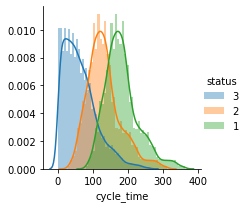

In [46]:
distplot_with_hue(data = train_df, hue='status',x='cycle_time')

## Split into testing and training datasets


While the dataset is already partitioned, we can drop several columns that are not useful for the prediction:
- ```dataset```
- ```unit_number```
- ```op_setting_1```, ```op_setting_2```, ```op_setting_3``` which we know are not changing in this dataset
- ```s1```, ```s5```, ```s6```, ```s10```, ```s16```, ```s18```, ```s19``` that are constant thorughout the entire life of the engine
- ```op_regime``` as it's constant in this dataset

In [47]:
cols_to_drop = ['dataset','unit_number', 
        'op_setting_1', 'op_setting_2', 'op_setting_3',
        's1', 's5', 's6', 's10', 's16', 's18', 's19',
        'op_regime','RUL']
predictor_col = ['status']

features_df = train_df.drop(cols_to_drop + predictor_col, axis=1)

feature_list = features_df.columns
data_types = features_df.dtypes
X_train = features_df.to_numpy()
y_train = train_df[predictor_col].to_numpy()

In [48]:
X_test = test_df.drop(cols_to_drop + predictor_col, axis=1).to_numpy()
y_test = test_df[predictor_col].to_numpy()

In [49]:
#Checking that the array dimensions are consistent
print('X_train shape :', X_train.shape)
print('X_test shape :', X_test.shape)
print('y_train shape :', y_train.shape)
print('y_test shape :', y_test.shape)

X_train shape : (20631, 15)
X_test shape : (13096, 15)
y_train shape : (20631, 1)
y_test shape : (13096, 1)


### Standardize the magnitude of numeric features

In [50]:
#scale data
from sklearn.preprocessing import MinMaxScaler

# build scaler based on training data and apply it to test data to then also scale the test data
scaler = MinMaxScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [51]:
#save data
import joblib

# Save the scaler
joblib.dump(scaler, '../data/scaler.pkl')

# Save data
pd.DataFrame(X_train_scaled).to_csv('../data/X_train_scaled.csv', index = None)
pd.DataFrame(y_train).to_csv('../data/y_train.csv', index = None)
pd.DataFrame(X_test_scaled).to_csv('../data/X_test_scaled.csv', index = None)
pd.DataFrame(y_test).to_csv('../data/y_test.csv', index = None)
pd.DataFrame(data_types).reset_index().to_csv("../data/data_types.csv", index = None)
pd.DataFrame(feature_list).reset_index().to_csv("../data/feature_list.csv", index = None)


In [52]:
pd.DataFrame(np.concatenate((X_train_scaled , y_train), axis=1)).to_csv('../data/all_train_Scaled.csv', index = None)

```python
#First Save the Model

joblib.dump(regressor, "regressor.sav")
#Save columns in order

pd.DataFrame(X_train.columns).to_csv("feature_list.csv", index = None)
#Save data types of train set

pd.DataFrame(X_train.dtypes).reset_index().to_csv("data_types.csv", index = None)
#Using it again:

feature_list = pd.read_csv("feature_list.csv")
feature_list = pd.Index(list(feature_list["0"]))

add_cols = list(feature_list.difference(X_test.columns))

drop_cols = list(X_test.columns.difference(feature_list))

for col in add_cols:
    X_test[col] = np.nan

for col in drop_cols:
    X_test = X_test.drop(col, axis = 1)

# reorder columns
X_test = X_test[feature_list]

types = pd.read_csv("data_types.csv")
for i in range(len(types)):
    X_test[types.iloc[i,0]] = X_test[types.iloc[i,0]].astype(types.iloc[i,1])
#Make Predictions

regressor = joblib.load("regressor.sav")
predictions = regressor.predict(X_test)
#Save Prediction Results

res = pd.DataFrame(predictions)
res.index = X_test.index # its important for comparison
res.columns = ["prediction"]
res.to_csv("prediction_results.csv")
```